# 1.1. Pre-procesamiento

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd

import torch
import pytorch_common.util as pu

import logging

from data.fashion import FeatureColumnBuilder
import data  as dt

import model as ml
import util  as ut

from sklearn.model_selection import train_test_split

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [2]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

Fijamos la semilla:

In [3]:
ut.set_seed(42)

Parametros de la notebook:

In [4]:
DATASET_PATH = '../../datasets/fashion-outfits'

### Funciones helper

In [5]:
def plot_columns(df, x_col, y_col, title):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x_col, y=y_col, data=df,  orient = 'h', order = df[y_col].values)
    ax.set(xlabel=x_col)
    ax.set(ylabel=y_col)
    ax.set(yticklabels=[])
    ax.set_title(title)
    plt.show()

    
def plot_branch_count(df):
    plot_columns(
        df, 
        y_col = 'branch', 
        x_col = 'count', 
        title = 'Cantidad de productos por rama del arbol de categorias'
    )
    
    
def plot_tokens_count(df, column='description', figsize=(20, 10)):
    values = df[column] \
        .apply(lambda x: len(x.split(' '))) \
        .value_counts()
    values.plot(
            kind    = 'bar', 
            rot     = 90,
            xlabel  = 'Cant. Tokens',
            ylabel  = 'Cant. Productos',
            title   = f'{column}: Cantidad de tokens',
            figsize = figsize
        )
    print('Max tokens count:',values.index.max())
    

def to_lower_strip(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: x.lower().strip())


def columns_to_dict(df, key_col, value_col):
    return pd.Series(df[key_col].values,index=df[value_col]).to_dict()

## Preparar dataset

**Step 1**: Cargamos el dataset original.

In [6]:
train_set = pd.read_parquet(f'{DATASET_PATH}/train_set.parquet')
test_set  = pd.read_csv(f'{DATASET_PATH}/test_set.csv')

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276107 entries, 388498 to 86966
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   product_id                 276107 non-null  int32 
 1   product_family             276107 non-null  object
 2   product_category           276107 non-null  object
 3   product_sub_category       276107 non-null  object
 4   product_gender             276107 non-null  object
 5   product_main_colour        276107 non-null  object
 6   product_second_color       276098 non-null  object
 7   product_brand              276107 non-null  object
 8   product_materials          276013 non-null  object
 9   product_short_description  276107 non-null  object
 10  product_attributes         163191 non-null  object
 11  product_image_path         276107 non-null  object
 12  product_highlights         265625 non-null  object
 13  branch                     276107 non-nu

In [7]:
train_set.head(2)

,product_id,product_family,product_category,product_sub_category,product_gender,product_main_colour,product_second_color,product_brand,product_materials,product_short_description,product_attributes,product_image_path,product_highlights,branch
388498,14034428,Clothing,Coats,Trench & Raincoats,WOMEN,NEUTRALS,N/D,BURBERRY,"[Leather, Cupro, Buffalo Horn, Cotton]",The Islington trench coat,"[{""attribute_name"":""Body Length"",""attribute_va...",14/03/44/28/14034428.jpg,"[honey beige, cotton, spread collar, double-br...",Clothing~Coats~Trench & Raincoats
20555,16595992,Clothing,Dresses,Day Dresses,WOMEN,BLACK,N/D,THOM KROM,"[viscose, Spandex/Elastane, Cotton]",sleeveless fitted maxi dress,"[{""attribute_name"":""Dress Length"",""attribute_v...",16/59/59/92/16595992.jpg,"[black, stretch-cotton, round neck, sleeveless...",Clothing~Dresses~Day Dresses


**Step 2**

* Normalizamos nombres de columnas y las variables categoricas.
* Borramos columnas y filas con nulos.
* Seleccionamos columnas de interés.
* Construimos la columnas branch. El branch es larama en la que se encuentra un producto dentro del arbol de categorias del e-commerce. Esta esta compuesta por:
    1. Familia.
    2. Categoria
    3. Sub categoria.

Normalización:

In [8]:
to_lower_strip(train_set, ['product_family', 'product_category', 'product_sub_category', 'product_brand', 'product_gender'])
to_lower_strip(test_set, ['product_family', 'product_category', 'product_sub_category', 'product_brand', 'product_gender'])

Renombrado de columnas:

In [9]:
rename_columns = {
    'product_id'               : 'id',
    'product_gender'           : 'gender',    
    'product_short_description': 'description', 
    'product_highlights'       : 'highlights',
    'product_image_path'       : 'image',
    'product_materials'        : 'materials',
    'product_family'           : 'family',
    'product_category'         : 'category',
    'product_sub_category'     : 'sub_category', 
    'product_brand'            : 'brand',
    'product_main_colour'      : 'main_colour', 
    'product_second_color'     : 'second_color',
    'product_image_path'       : 'image_uri'
}

train_set = train_set.rename(columns = rename_columns)
test_set  = test_set.rename(columns  = rename_columns)

Selección de columnas de interés:

In [10]:
cols = [
    'id', 
    'family', 
    'category', 
    'sub_category', 
    'description', 
    'highlights', 
    'brand', 
    'gender', 
    'materials', 
    'image_uri'
]

train_products = train_set[cols]
test_products  = test_set[cols]

Construimos la columna branch:

In [11]:
train_products['branch'] = train_products['family'] + '~' + train_products['category'] + '~' + train_products['sub_category']
test_products['branch']  = test_products['family']  + '~' + test_products['category']  + '~' + test_products['sub_category']

Borramos filas y columnas que tengan todos sus valores nulos: 

In [12]:
train_products = train_products.dropna(how='all', axis=1).dropna(axis=0)
test_products  = test_products.dropna(how='all', axis=1).dropna(axis=0)
None

In [13]:
train_products.head(2)

,id,family,category,sub_category,description,highlights,brand,gender,materials,image_uri,branch
388498,14034428,clothing,coats,trench & raincoats,The Islington trench coat,"[honey beige, cotton, spread collar, double-br...",burberry,women,"[Leather, Cupro, Buffalo Horn, Cotton]",14/03/44/28/14034428.jpg,clothing~coats~trench & raincoats
20555,16595992,clothing,dresses,day dresses,sleeveless fitted maxi dress,"[black, stretch-cotton, round neck, sleeveless...",thom krom,women,"[viscose, Spandex/Elastane, Cotton]",16/59/59/92/16595992.jpg,clothing~dresses~day dresses


Creamos un archivo con todas la catagorias que se encuentra en el dataset de entranamiento:

In [14]:
train_products[['branch']] \
    .drop_duplicates() \
    .sort_values(by=['branch']) \
    .to_csv(f'{DATASET_PATH}/train_branches.csv',  index=False)

**Step 3**: Definimos dos nuevas columnas : una contiene todos los tokens de la description y el otro su cantidad:

In [15]:
train_products['desc_tokens']  = train_products['description'].apply(lambda x: x.split(' '))
train_products['tokens_count'] = train_products['desc_tokens'].apply(len)

test_products['desc_tokens']  = test_products['description'].apply(lambda x: str(x).split(' '))
test_products['tokens_count'] = test_products['desc_tokens'].apply(len)

In [16]:
train_products['tokens_count'].min(), train_products['tokens_count'].max()

(1, 40)

In [17]:
test_products['tokens_count'].min(), test_products['tokens_count'].max()

(1, 10)

**Step 4**: Seleccionamos las columnas y tipos de datos finales.

In [18]:
cols =  [
    'id', 
    'family', 
    'category', 
    'sub_category',
    'description',
    'highlights',
    'brand',
    'gender',
    'materials',
    'branch', 
    'tokens_count',
    'image_uri'
]
col_types = {    
    'id': int,
    'family': str,
    'category': str,
    'sub_category': str,
    'brand': str,
    'gender': str,
    'branch': str,
    'description': str
}

In [19]:
train_products = train_products[cols]
train_products = train_products.dropna(how='all', axis=1).dropna(axis=0)
train_products = train_products.astype(col_types)

test_products = test_products[cols]
test_products = test_products.dropna(how='all', axis=1).dropna(axis=0)
test_products = test_products.astype(col_types)

train_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265556 entries, 388498 to 86966
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            265556 non-null  int64 
 1   family        265556 non-null  object
 2   category      265556 non-null  object
 3   sub_category  265556 non-null  object
 4   description   265556 non-null  object
 5   highlights    265556 non-null  object
 6   brand         265556 non-null  object
 7   gender        265556 non-null  object
 8   materials     265556 non-null  object
 9   branch        265556 non-null  object
 10  tokens_count  265556 non-null  int64 
 11  image_uri     265556 non-null  object
dtypes: int64(2), object(10)
memory usage: 26.3+ MB


**Step 5**: Juntamos las categorias que confunden el modelo y ademas son muy similares entre si.

In [20]:
train_products['branch'].unique().shape

(194,)

In [21]:
test_products['branch'].unique().shape

(194,)

In [22]:
similar_categories = {
  'clothing~coats~oversized coats'       : 'clothing~coats~single breasted coats',
  'clothing~jackets~cropped jackets'     : 'clothing~jackets~fitted jackets',
  'clothing~jackets~lightweight jackets' : 'clothing~jackets~sport jackets & windbreakers',
  'clothing~trousers~skinny trousers'    : 'clothing~trousers~slim-fit trousers'
}

train_products['branch'] = train_products['branch'].apply(lambda x: similar_categories[x] if x in similar_categories else x)
test_products['branch']  = test_products['branch'].apply(lambda x: similar_categories[x] if x in similar_categories else x)

In [23]:
train_products['branch'].unique().shape

(190,)

In [24]:
test_products['branch'].unique().shape

(190,)

**Step 6**: Dowsampling de clases mayoritarias. Dado que tenemos un gran nivel de desbalance de las clases, se realizara un downsampling, es decir tomar un máximo de ejemplos para las clases mayoritarias. De esta forma, se intenta aumentar el balance de clases en el dataset.

In [25]:
train_products_by_branch = ut.group_by_count(train_products, 'branch', 'id')
train_products_by_branch.head()

,branch,count
129,clothing~t-shirts & vests~t-shirts,17358
69,clothing~dresses~day dresses,14824
138,clothing~tops~t-shirts & jerseys,11343
34,bags~tote bags~n/d,10126
100,clothing~shirts~n/d,9866


In [26]:
test_products_by_branch = ut.group_by_count(test_products, 'branch', 'id')
test_products_by_branch.head()

,branch,count
129,clothing~t-shirts & vests~t-shirts,7488
69,clothing~dresses~day dresses,6363
138,clothing~tops~t-shirts & jerseys,4874
34,bags~tote bags~n/d,4343
100,clothing~shirts~n/d,4235


<Figure size 800x500 with 1 Axes>

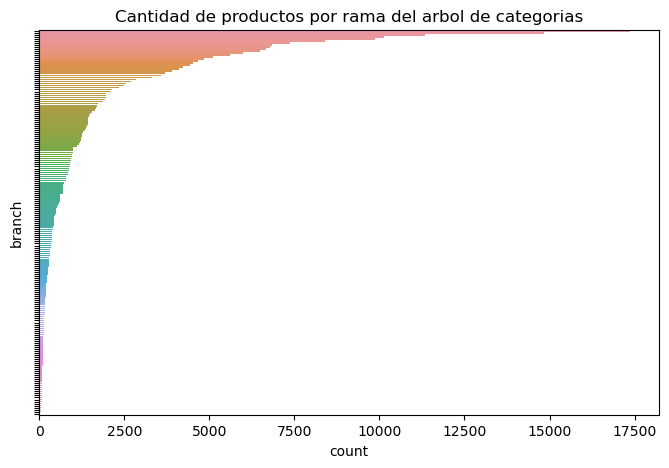

In [27]:
plot_branch_count(train_products_by_branch)

In [28]:
train_max_products = train_products_by_branch['count'].max()
train_min_products = train_products_by_branch['count'].min()

train_min_products, train_max_products

(26, 17358)

In [29]:
train_products.branch.nunique()

190

In [30]:
test_products.branch.nunique()

190

In [31]:
branchs_count = train_products.branch.value_counts()
branchs_count

clothing~t-shirts & vests~t-shirts             17358
clothing~dresses~day dresses                   14824
clothing~tops~t-shirts & jerseys               11343
bags~tote bags~n/d                             10126
clothing~shirts~n/d                             9866
                                               ...  
demi-fine jewellery~demi-fine necklaces~n/d       45
fine jewellery~fine rings~n/d                     44
demi-fine jewellery~demi-fine earrings~n/d        44
fine jewellery~fine earrings~n/d                  44
fine jewellery~fine necklaces~n/d                 26
Name: branch, Length: 190, dtype: int64

In [32]:
description = branchs_count.describe(percentiles=list(np.arange(0, 1, 0.1)))
description

count      190.000000
mean      1397.663158
std       2496.592205
min         26.000000
0%          26.000000
10%         91.000000
20%        123.800000
30%        178.800000
40%        290.200000
50%        427.500000
60%        716.000000
70%       1129.500000
80%       1680.200000
90%       4119.300000
max      17358.000000
Name: branch, dtype: float64

se excluyen ramas con menos de 10 productos:

In [38]:
MIN_PRODUCTS_BY_BRANCH = round(description[7])
MIN_PRODUCTS_BY_BRANCH = 0
MAX_PRODUCTS_BY_BRANCH = round(description[11])

MIN_PRODUCTS_BY_BRANCH, MAX_PRODUCTS_BY_BRANCH

(0, 1129)

In [39]:
data_balancer = dt.DataBalancer(
    train_products,
    min_n_instances = MIN_PRODUCTS_BY_BRANCH,
    max_n_instances = MAX_PRODUCTS_BY_BRANCH,
    class_col       = 'branch'
)

In [40]:
sampled_train_products = data_balancer()

Sampling...:   0%|          | 0/190 [00:00<?, ?it/s]

In [41]:
train_products.shape, sampled_train_products.shape

((265556, 12), (109412, 12))

<Figure size 800x500 with 1 Axes>

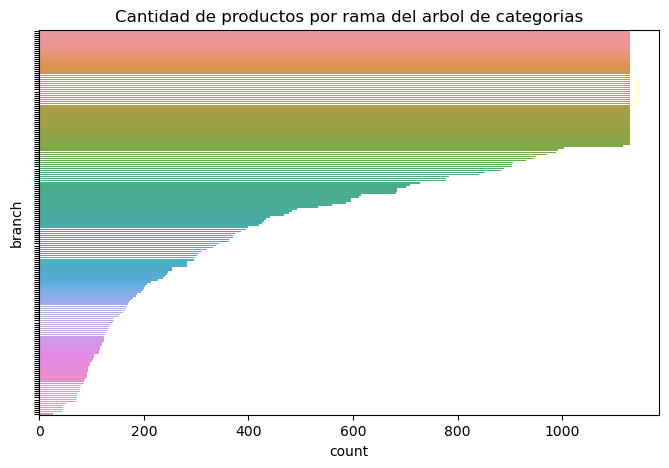

In [42]:
plot_branch_count(ut.group_by_count(sampled_train_products, 'branch', 'id'))

**Step 7**: Agregamos un número de secuencia que representa univocamente a cada branch:

In [43]:
sampled_train_products = dt.Sequencer('branch', 'branch_seq').perform(sampled_train_products)
sampled_train_products.head(2)

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq
0,17110732,accessories,belts,n/d,embroidered leather belt,"[multicolour, leather/cotton, buckle fastening...",etro,women,"[Cotton, Calfskin, viscose]",accessories~belts~n/d,3,17/11/07/32/17110732.jpg,0
1,16805990,accessories,belts,n/d,gilet leather belt,"[black, leather, silver-tone hardware, punched...",jil sander,men,[Leather],accessories~belts~n/d,3,16/80/59/90/16805990.jpg,0


Cual es el numero total de ramas en el dataset luego de los pasos anteriores?

In [44]:
sampled_train_products['branch_seq'].max()

189

Nos quedamos con instancias de test que tengan ramas qe se encuentren en train:

In [45]:
selected_test_products = test_products[test_products.branch.isin(sampled_train_products.branch.values)]

selected_test_products.shape, test_products.shape

((113884, 12), (113884, 12))

**Step 8**: Agregamos otros features a la descripción como genero, brand, highlights y materias para tratar de mejorar la predición.

Max tokens count: 26

<Figure size 800x500 with 1 Axes>

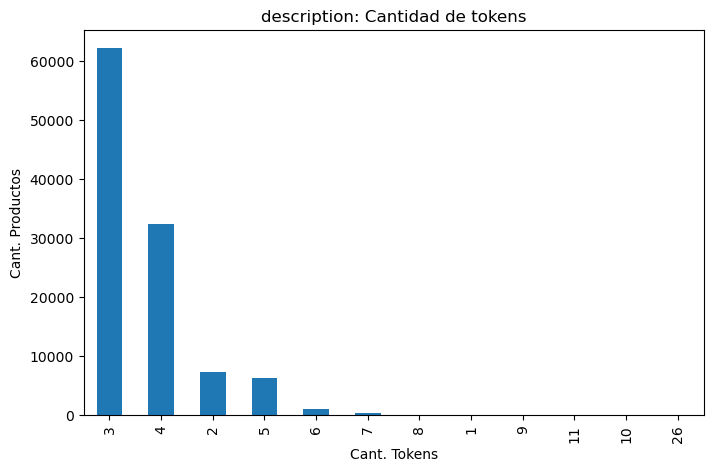

In [46]:
plot_tokens_count(sampled_train_products, figsize=(8, 5))

**FeatureColumnBuilder** Se encarga de concatenar y transformar cada columna a una lista de tokens dependiendo de su formato/tipo de datos. De esta forma creamos una nueva columna llamada **features** la cual es una concatenacion de los tokens de cada coluna seleciconada con un label que identifica a la columna. Se espera que el modelo peuda comprander que cada token esta asociada a una columna en particula. Por ejemplo: token que defines manterias estaran tageados con  la columnas **materials**.

In [47]:
builder = FeatureColumnBuilder(target_column='features') \
    .add('description') \
    .add('gender') \
    .add('brand') \
    .add('materials', type='list', max_tokens=10)

In [48]:
sampled_train_products = builder(sampled_train_products)

sampled_train_products['features'].values[100]

'Description: double-strap leather belt. Gender: women. Brand: bottega veneta. Materials: Leather, metal. '

In [49]:
builder = FeatureColumnBuilder(target_column='features') \
    .add('description') \
    .add('gender') \
    .add('brand') \
    .add('materials', type='str_list', max_tokens=10)

In [50]:
selected_test_products = builder(selected_test_products)

selected_test_products['features'].values[102]

'Description: roll-neck jumper. Gender: men. Brand: dondup. Materials: Merino Cashmere. '

Veamos cuantos token nos queda en promedio luego del proceso anterior:

Max tokens count: 35

<Figure size 2000x500 with 1 Axes>

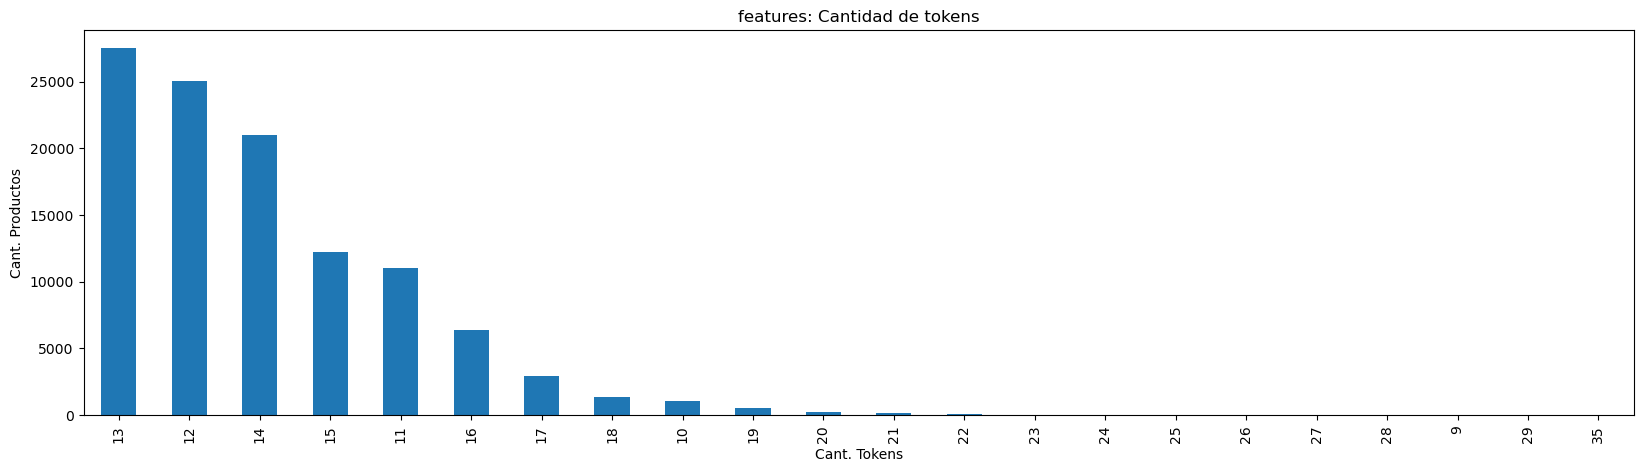

In [51]:
plot_tokens_count(sampled_train_products, column='features',figsize=(20, 5))

Max tokens count: 28

<Figure size 2000x500 with 1 Axes>

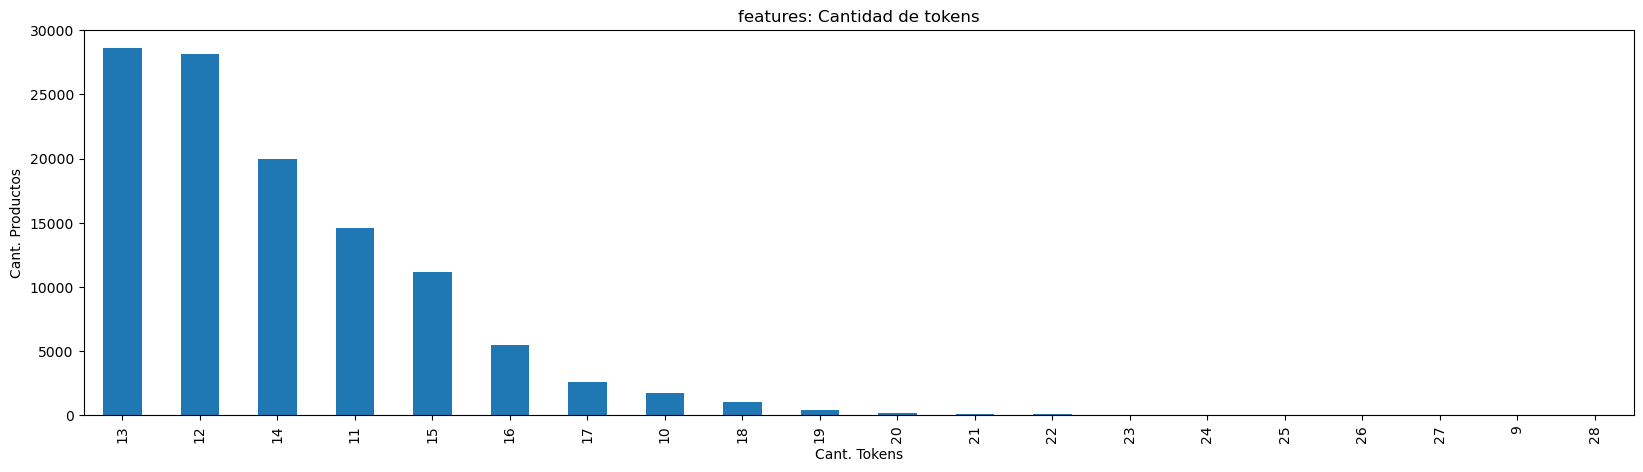

In [52]:
plot_tokens_count(selected_test_products, column='features',figsize=(20, 5))

**Step 9**: Partimos el dataset en los conjuntos de entrenamiento, prueba y validación. Ademas se estratifica para minizar el efecto del desbalanceo de productos por branch.

In [53]:
TRAIN_SIZE = 0.97

In [54]:
train_set, val_set, _, _= train_test_split(
    sampled_train_products,
    sampled_train_products['branch_seq'].values,
    test_size     = 1 - TRAIN_SIZE,
    stratify      = sampled_train_products['branch_seq'].values,
    shuffle       = True
)

Realizamos una validacion grafica de balanceo de cada conjunto luego de split:

<Figure size 800x500 with 1 Axes>

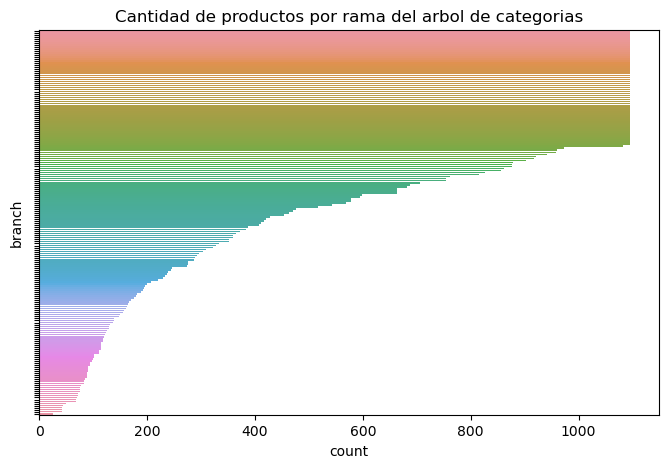

In [55]:
plot_branch_count(ut.group_by_count(train_set, 'branch', 'id'))

<Figure size 800x500 with 1 Axes>

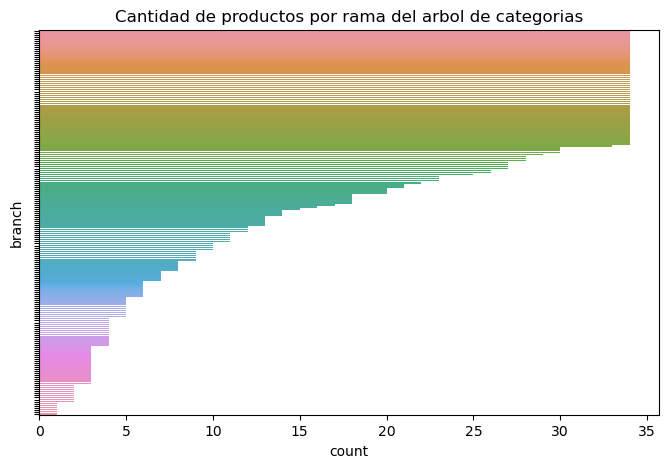

In [56]:
plot_branch_count(ut.group_by_count(val_set, 'branch', 'id'))

In [57]:
train_set.shape, val_set.shape

((106129, 14), (3283, 14))

**Step 10**: Los sets de validación y test deberian tener solo categorias que existan en el set de entrenamiento, de lo contrario, no es posible hacer la predicción.

In [58]:
train_set.branch.value_counts().tail()

demi-fine jewellery~demi-fine necklaces~n/d    44
fine jewellery~fine rings~n/d                  43
fine jewellery~fine earrings~n/d               43
demi-fine jewellery~demi-fine earrings~n/d     43
fine jewellery~fine necklaces~n/d              25
Name: branch, dtype: int64

In [59]:
val_set[val_set['branch_seq'].isin(train_set['branch_seq'].values)].shape

(3283, 14)

In [60]:
selected_test_products.shape, \
selected_test_products[selected_test_products['branch'].isin(train_set['branch'].values)].shape

((113884, 13), (113884, 13))

**Step 11**: Se agrega la columna **branch_seq** en el conjunto de prueba.

In [61]:
sampled_train_products.head(2)

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,branch_seq,features
0,17110732,accessories,belts,n/d,embroidered leather belt,"[multicolour, leather/cotton, buckle fastening...",etro,women,"[Cotton, Calfskin, viscose]",accessories~belts~n/d,13,17/11/07/32/17110732.jpg,0,Description: embroidered leather belt. Gender:...
1,16805990,accessories,belts,n/d,gilet leather belt,"[black, leather, silver-tone hardware, punched...",jil sander,men,[Leather],accessories~belts~n/d,12,16/80/59/90/16805990.jpg,0,Description: gilet leather belt. Gender: men. ...


In [62]:
branch_to_seq = columns_to_dict(sampled_train_products, key_col='branch_seq', value_col='branch')

In [63]:
selected_test_products['branch_seq'] = selected_test_products['branch'].apply(lambda x: branch_to_seq[x])

In [64]:
selected_test_products.head(2)

,id,family,category,sub_category,description,highlights,brand,gender,materials,branch,tokens_count,image_uri,features,branch_seq
0,17887434,clothing,sweaters & knitwear,hoodies,Archive 1971 graphic-print hoodie,"[white, cotton, jersey knit, graphic print to ...",valentino,men,['Cotton'],clothing~sweaters & knitwear~hoodies,12,17/88/74/34/17887434.jpg,Description: Archive 1971 graphic-print hoodie...,124
2,17933530,clothing,trousers,track pants,logo-print joggers,"[black, cotton, logo print to the side, elasti...",bel-air athletics,men,['Cotton'],clothing~trousers~track pants,11,17/93/35/30/17933530.jpg,Description: logo-print joggers. Gender: men. ...,155


**Step 12**: Guardamos todos los conjuntos preprocesados.

In [65]:
sampled_train_products[['branch']] \
    .drop_duplicates() \
    .sort_values(by=['branch']) \
    .to_csv(f'{DATASET_PATH}/bert_dev_branches.csv',  index=False)

In [66]:
sampled_train_products.to_csv(f'{DATASET_PATH}/bert_all_train.csv', index=False)
train_set.to_csv(f'{DATASET_PATH}/bert_train.csv', index=False)
val_set.to_csv(f'{DATASET_PATH}/bert_val.csv',  index=False)
selected_test_products.to_csv(f'{DATASET_PATH}/bert_test.csv',  index=False)